# Geo Spatial Data Analysis Challenge

## The goal of this task is to do the following
1. Data is provided in .nc file. Do the following calculation. 
   
    ● Calculation of the Normalized Difference Vegetation Index (NDVI) over
        the entire AOI for each date given in the data cube and added as a
        separate data layer in the same provided data cube
    <break>

    ● A visual RGB image of one date

    ● Distribution (histogram) of NDVI pixels

    ● Time series of NDVI averaged over the AOI

3. A brief description of your interpretation of the spatial distribution and
evolution of the NDVI/vegetation
4. A visualization of NDVI clipped to the provided sub-AOI


## First let's load the data. 
The data is available at this [link](https://drive.google.com/file/d/1LmTwGyFJb8gmoxH6uibyo360PTcnM5qk/view) 
Download it and put it in the same directory as this notebook. 
The geojson file (no need to download) contains the cordinates of the area of interest. 

## We can take out the data that does NOT belong to our area of interest. 

In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import xarray as xr
from rasterio.mask import geometry_mask

# Load the NetCDF file
data_cube = xr.open_dataset("geospatial_test_datacube.nc")

# Read the GeoJSON file containing AOI polygon coordinates
aoi_gdf = gpd.read_file('geospatial_sub_aoi.geojson')

# Assuming the AOI polygon is the first feature in the GeoDataFrame
aoi_polygon = aoi_gdf
# Convert the AOI polygon to the same CRS as your data cube
aoi_polygon = aoi_polygon.to_crs(data_cube.crs)

# Generate a mask from the AOI polygon
mask = geometry_mask([aoi_polygon.geometry.values[0]], out_shape=data_cube['S2_RED'][0].shape,
                     transform=data_cube.transform, invert=True)
print("The shape before filtering {}".format(data_cube['S2_RED'][0].shape))

print("Valid values in this mask {} ".format(mask.sum()))
print("Total values in the region {}".format(data_cube['S2_RED'][0].shape[0] * data_cube['S2_RED'][0].shape[1]))
# Apply the mask to the data cube
data_cube_aoi = data_cube.where(mask)

print(data_cube_aoi['S2_RED'][0].shape)

# Now data_cube_aoi contains only the subset of data within the specified AOI polygon


/root/anaconda3/envs/spacesense/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


The shape before filtering (227, 304)
Valid values in this mask 31004 
Total values in the region 69008
(227, 304)


## Lets verify that the region is correct or not. 

###  Plot the shape of given polygon

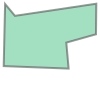

In [2]:
aoi_polygon['geometry'][0]

### Lets check that this polygon is there on the map. 

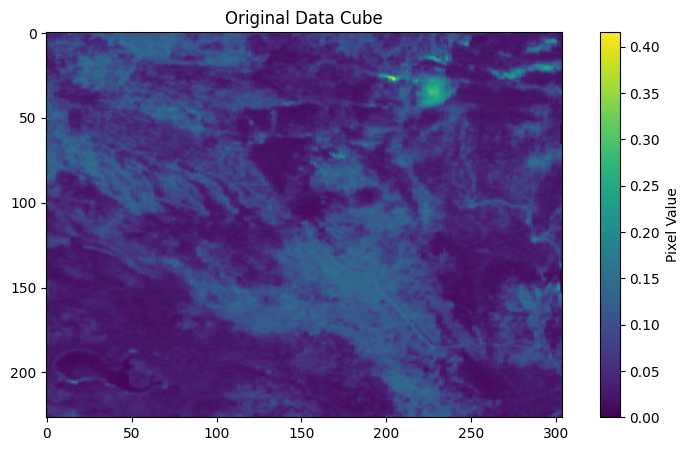

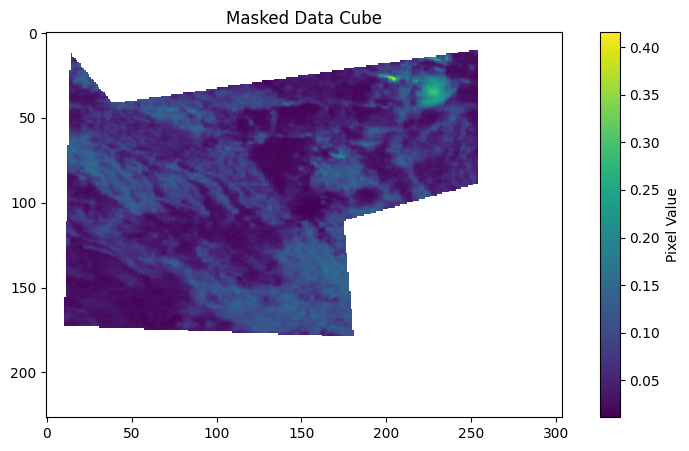

In [3]:
import matplotlib.pyplot as plt

# Plot the original data cube
plt.figure(figsize=(10, 5))
plt.imshow(data_cube['S2_RED'][0], cmap='viridis')  # Assuming 'S2_RED' represents one of the bands
plt.title('Original Data Cube')
plt.colorbar(label='Pixel Value')
plt.show()

# Plot the masked data cube
plt.figure(figsize=(10, 5))
plt.imshow(data_cube_aoi['S2_RED'][0], cmap='viridis')  # Assuming 'S2_RED' represents one of the bands
plt.title('Masked Data Cube')
plt.colorbar(label='Pixel Value')
plt.show()


### Now let's first verify that time interval is smae for both the bands S2_RED and S2_NIR

In [4]:
print("Total time intervals in In Infra Red Band {}".format(len(data_cube_aoi['S2_RED'])))
print("Total time intervals in In Near Red Band {}".format(len(data_cube_aoi['S2_NIR'])))

Total time intervals in In Infra Red Band 23
Total time intervals in In Near Red Band 23


### So the time interval is same for both of them.

### Also check we are calculating for the same time interval for both these bands.


In [5]:
      
for i in range(len(data_cube_aoi['S2_RED'])):
    if (data_cube_aoi['S2_RED'][i]['time'] != data_cube_aoi['S2_NIR'][i]['time']):
        print("Not same")

### So they are indeed the same.

## Now let's finally calculate the ndvi values.

In [6]:

# Define a function to calculate NDVI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red)

for i in range(len(data_cube_aoi['S2_RED'])):
    nir_band = data_cube_aoi['S2_NIR'].sel(time=data_cube_aoi['S2_NIR'][i]['time'])
    red_band = data_cube_aoi['S2_RED'].sel(time=data_cube_aoi['S2_RED'][i]['time'])
    
    # Calculate NDVI
    ndvi = calculate_ndvi(nir_band, red_band)
    # Since both bands have dates does not matter.
    date_value = str(data_cube_aoi['S2_RED'][i]['time'].values).split("T")[0]
    # Add the NDVI layer to the data cube for the current date
    data_cube_aoi['NDVI_' + date_value] = ndvi
data_cube_aoi.keys()

KeysView(<xarray.Dataset> Size: 32MB
Dimensions:          (time: 23, y: 227, x: 304)
Coordinates:
  * time             (time) datetime64[ns] 184B 2021-04-09 ... 2021-11-25
  * y                (y) float32 908B 45.23 45.23 45.23 ... 45.21 45.21 45.21
  * x                (x) float32 1kB -69.95 -69.95 -69.95 ... -69.92 -69.92
Data variables: (12/27)
    S2_RED           (time, y, x) float32 6MB nan nan nan nan ... nan nan nan
    S2_GREEN         (time, y, x) float32 6MB nan nan nan nan ... nan nan nan
    S2_BLUE          (time, y, x) float32 6MB nan nan nan nan ... nan nan nan
    S2_NIR           (time, y, x) float32 6MB nan nan nan nan ... nan nan nan
    NDVI_2021-04-09  (y, x) float32 276kB nan nan nan nan ... nan nan nan nan
    NDVI_2021-04-14  (y, x) float32 276kB nan nan nan nan ... nan nan nan nan
    ...               ...
    NDVI_2021-10-09  (y, x) float32 276kB nan nan nan nan ... nan nan nan nan
    NDVI_2021-10-29  (y, x) float32 276kB nan nan nan nan ... nan nan nan nan


### Let's check NaN's

In [7]:
# data_cube_aoi['NDVI_2021-10-09'].isnan

print(np.isnan(data_cube_aoi['NDVI_2021-10-09']).sum())

<xarray.DataArray 'NDVI_2021-10-09' ()> Size: 8B
array(38004)


### We see that some values are NaN which is expected because they do not belong to the area of interest.

### Let's plot RGB image for NDVI values for the time 2021-10-09

/root/anaconda3/envs/spacesense/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


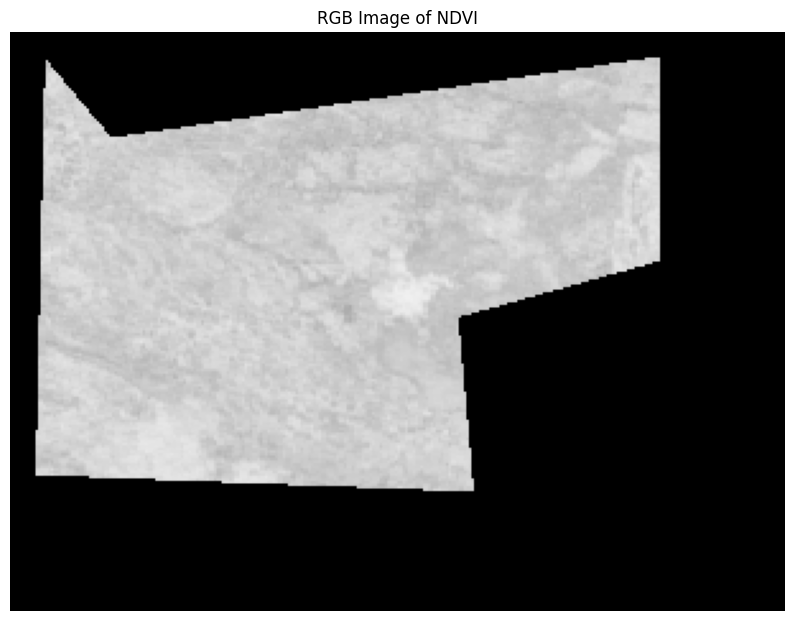

In [8]:
import matplotlib.pyplot as plt

# Assuming data_cube_aoi contains the NDVI values
ndvi = data_cube_aoi['NDVI_2021-10-09']  # get data for one dimension

# Rescale NDVI values to 0-255 range for display
ndvi_rgb = ((ndvi + 1) * 127.5).astype(np.uint8)

# Create an RGB image where NDVI values are assigned to the red channel
rgb_image = np.stack((ndvi_rgb, ndvi_rgb, ndvi_rgb), axis=-1)

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title('RGB Image of NDVI')
plt.axis('off')
plt.show()

### RGB image for IR, Red and Green bands. 

/root/anaconda3/envs/spacesense/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/root/anaconda3/envs/spacesense/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/root/anaconda3/envs/spacesense/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


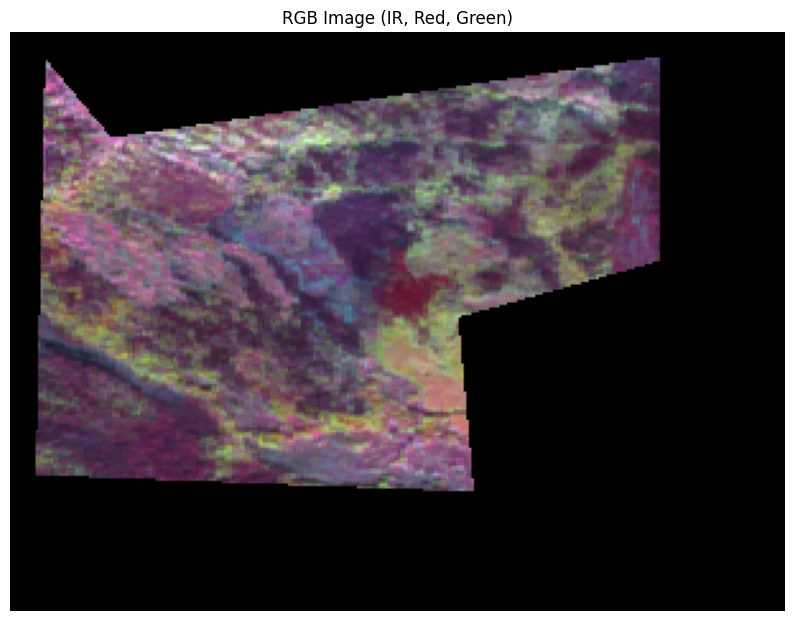

In [9]:
import matplotlib.pyplot as plt

# 2021-10-09 is at index 17
# Assuming data_cube_aoi contains the infrared, red, and green bands
ir_band = data_cube_aoi['S2_NIR'][17]  # Assuming 'S2_NIR' is the infrared band
red_band = data_cube_aoi['S2_RED'][17]  # Assuming 'S2_RED' is the red band
green_band = data_cube_aoi['S2_GREEN'][17]  # Assuming 'S2_GREEN' is the green band

# Rescale band values to 0-255 range for display
ir_rgb = ((ir_band / ir_band.max()) * 255).astype(np.uint8)
red_rgb = ((red_band / red_band.max()) * 255).astype(np.uint8)
green_rgb = ((green_band / green_band.max()) * 255).astype(np.uint8)

# Create an RGB image
rgb_image = np.stack((ir_rgb, red_rgb, green_rgb), axis=-1)

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title('RGB Image (IR, Red, Green)')
plt.axis('off')
plt.show()


### Let's look at various time intervals in the data. 

In [10]:
list(data_cube_aoi.keys())

['S2_RED',
 'S2_GREEN',
 'S2_BLUE',
 'S2_NIR',
 'NDVI_2021-04-09',
 'NDVI_2021-04-14',
 'NDVI_2021-04-27',
 'NDVI_2021-05-07',
 'NDVI_2021-05-19',
 'NDVI_2021-05-24',
 'NDVI_2021-05-29',
 'NDVI_2021-06-18',
 'NDVI_2021-07-28',
 'NDVI_2021-08-10',
 'NDVI_2021-08-12',
 'NDVI_2021-08-25',
 'NDVI_2021-09-04',
 'NDVI_2021-09-16',
 'NDVI_2021-09-19',
 'NDVI_2021-09-21',
 'NDVI_2021-10-06',
 'NDVI_2021-10-09',
 'NDVI_2021-10-29',
 'NDVI_2021-11-05',
 'NDVI_2021-11-20',
 'NDVI_2021-11-23',
 'NDVI_2021-11-25']

## For each of these time intervals.Let's plot the distribution of ndvi values. 

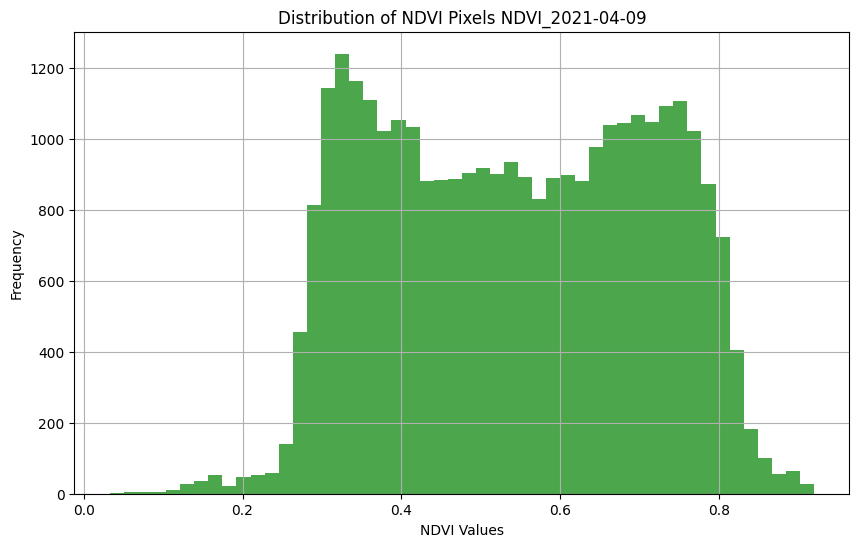

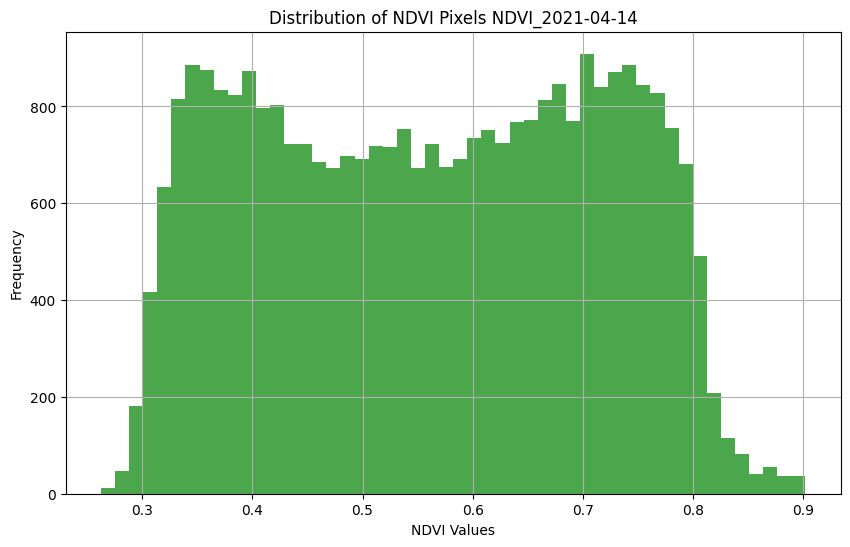

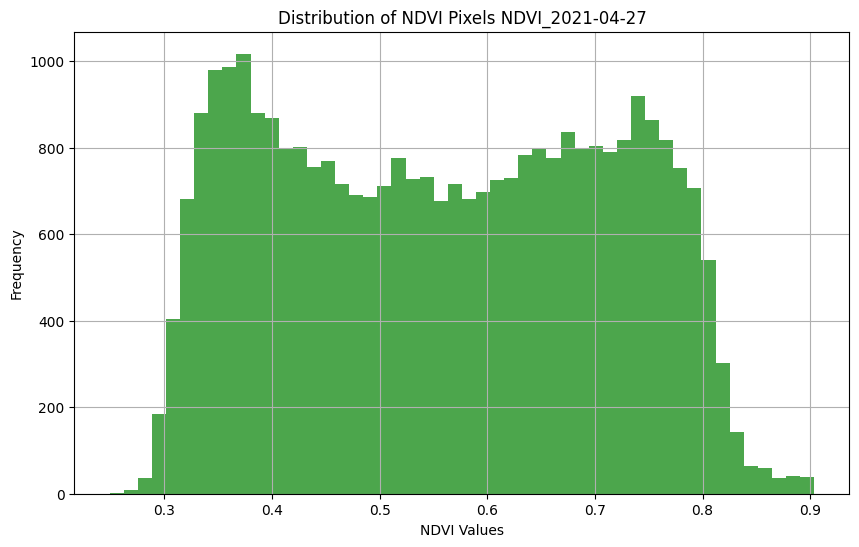

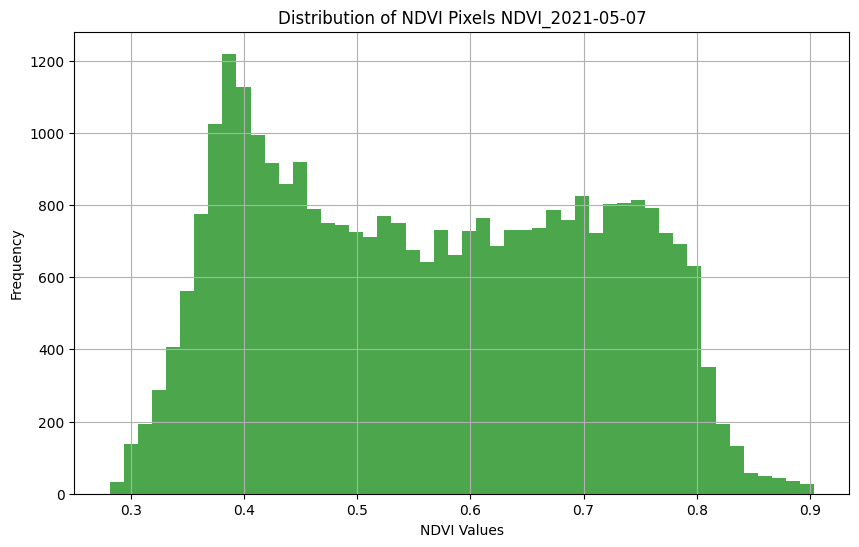

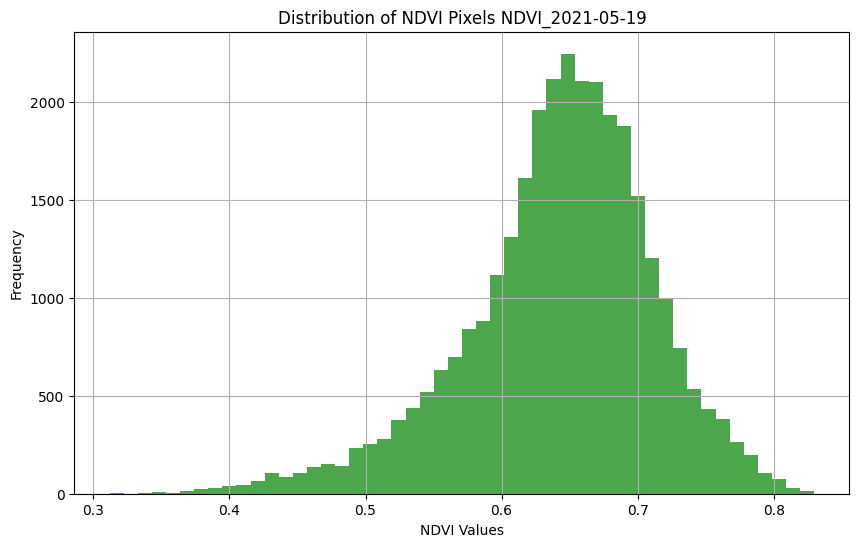

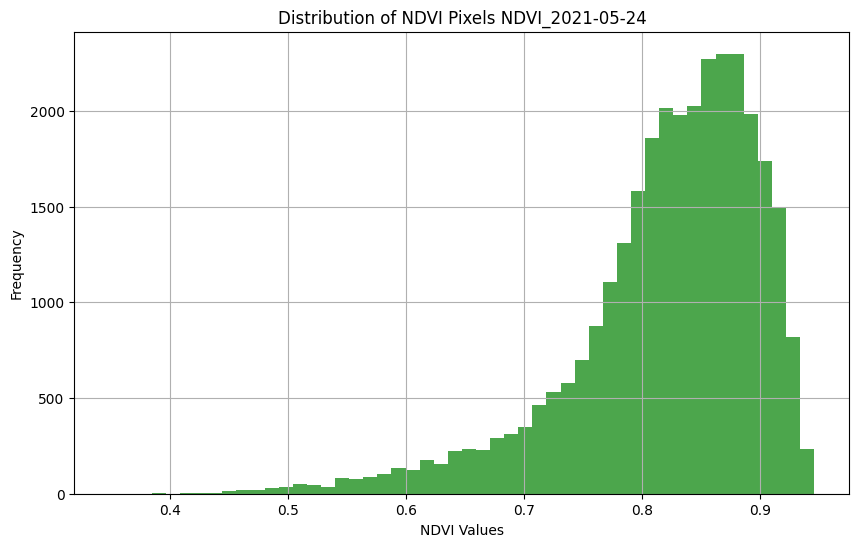

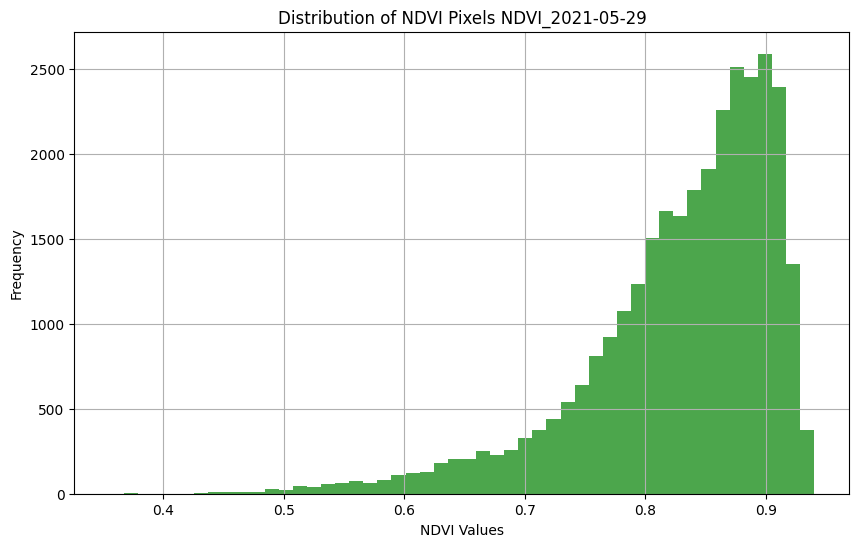

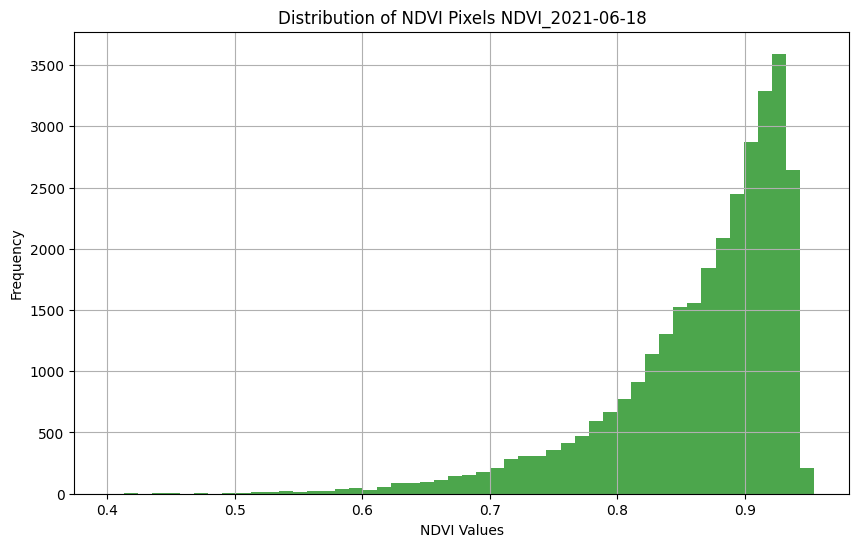

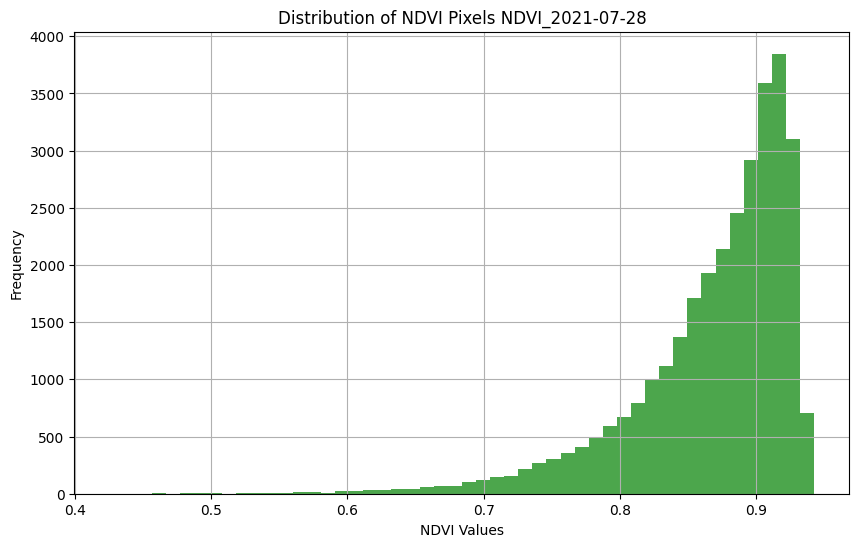

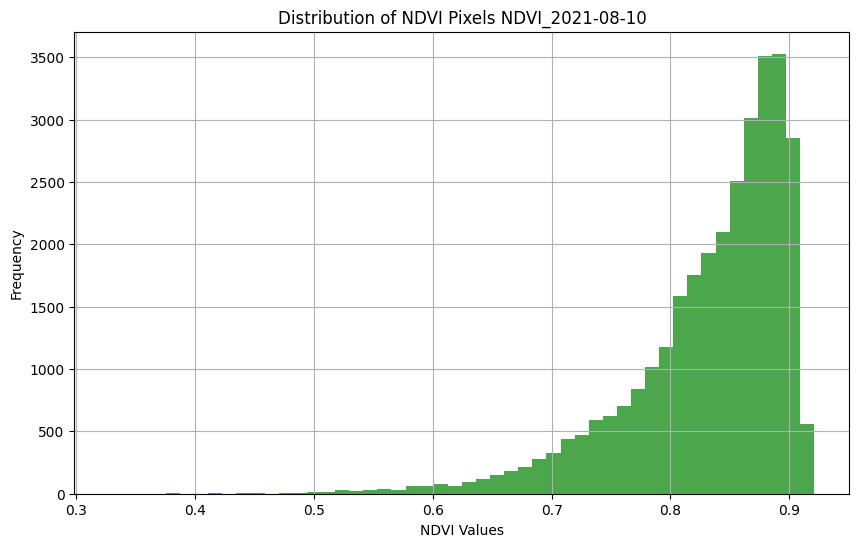

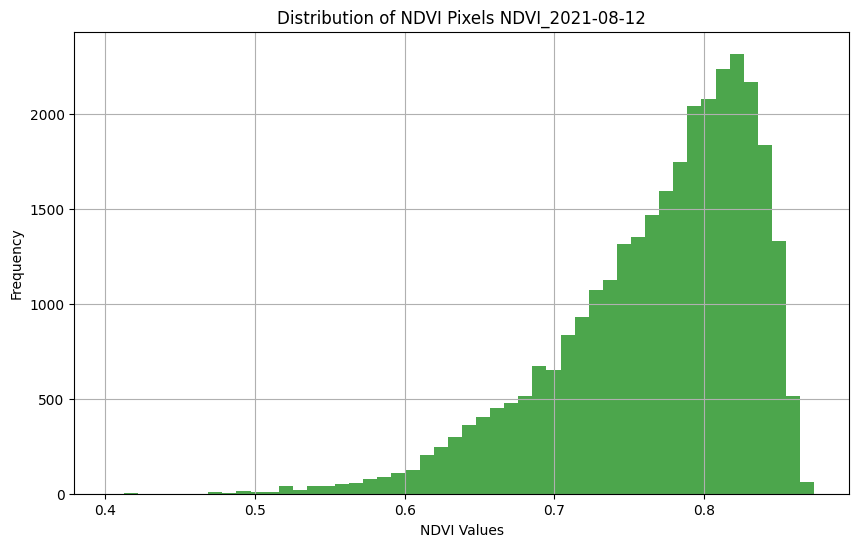

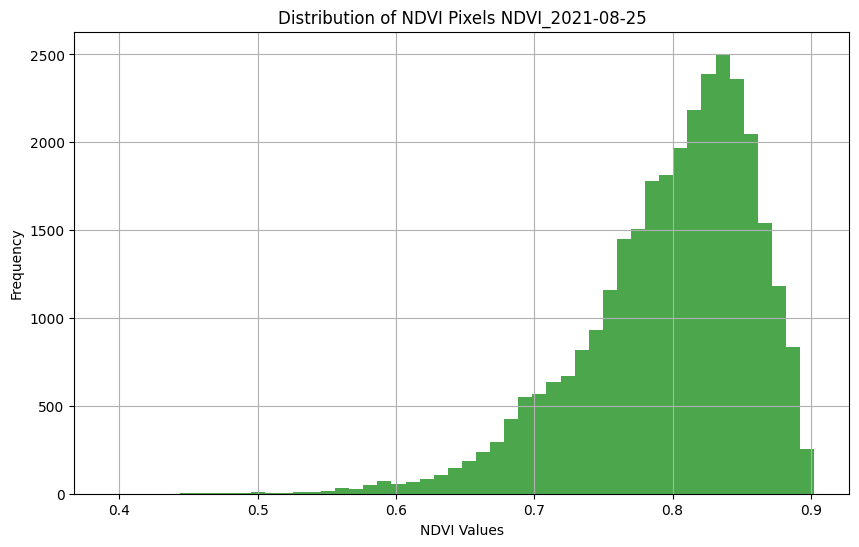

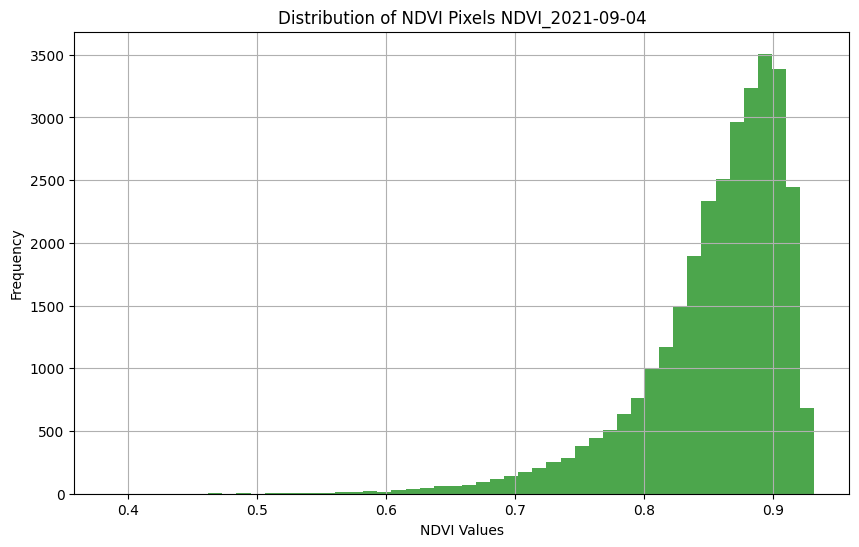

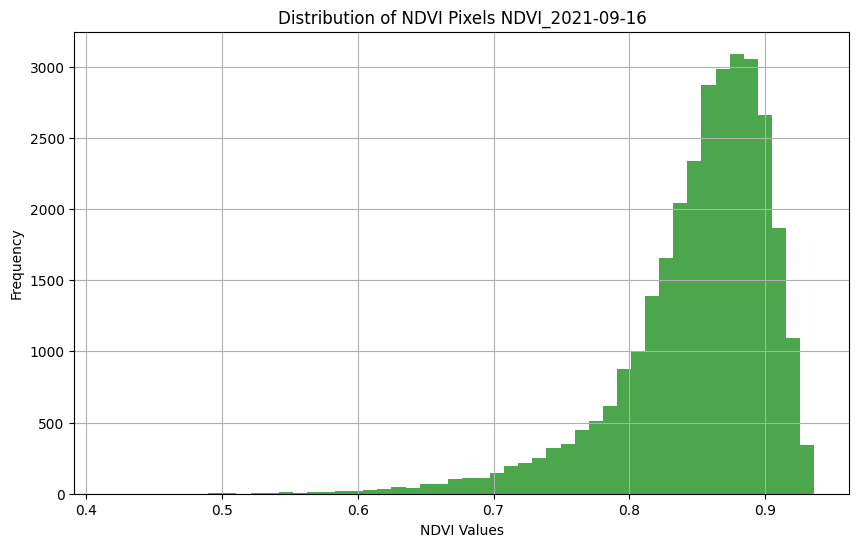

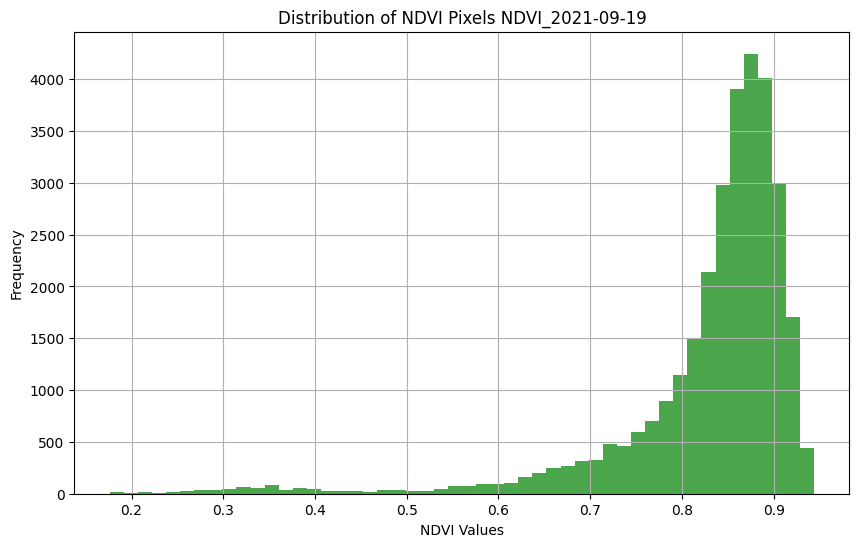

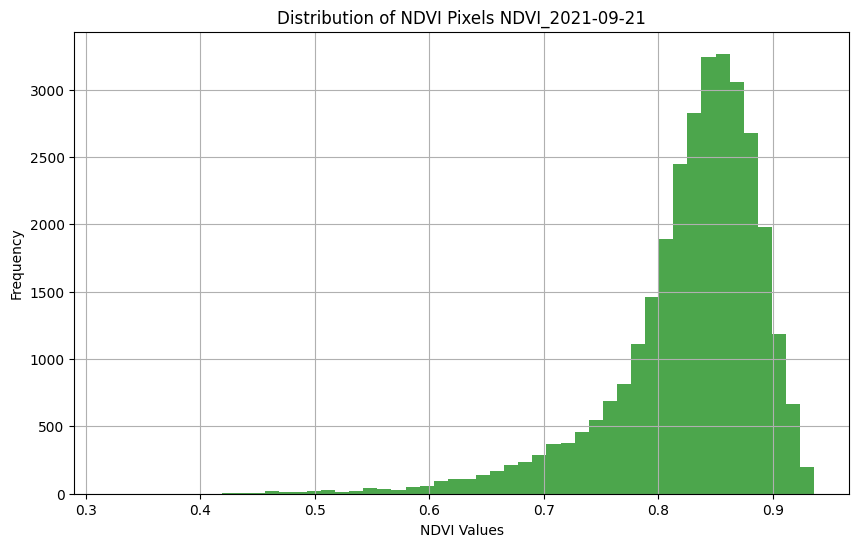

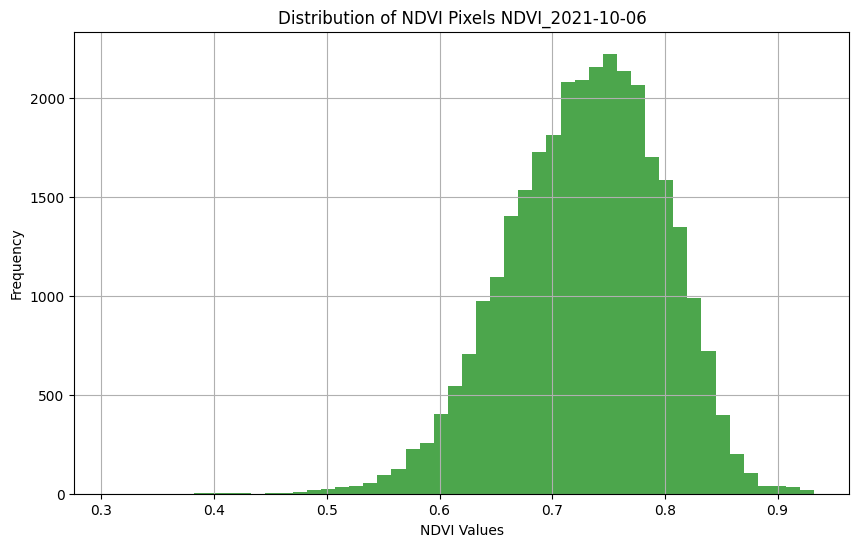

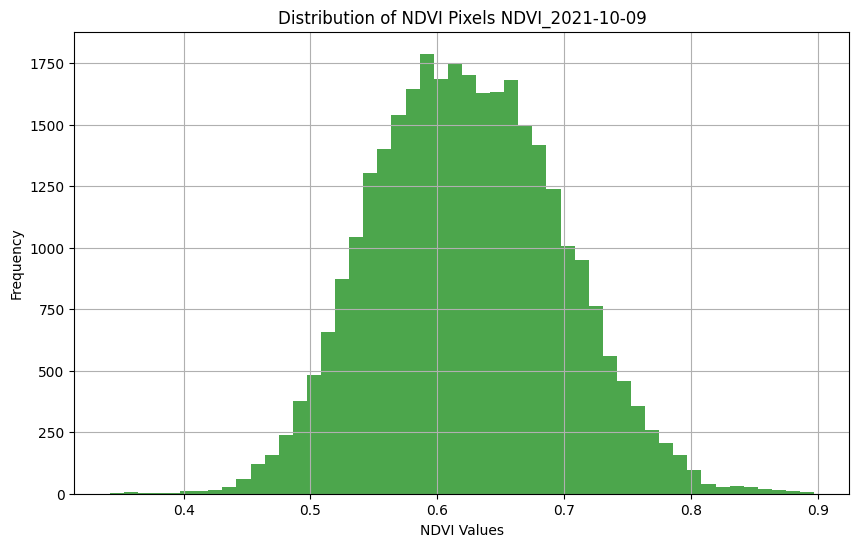

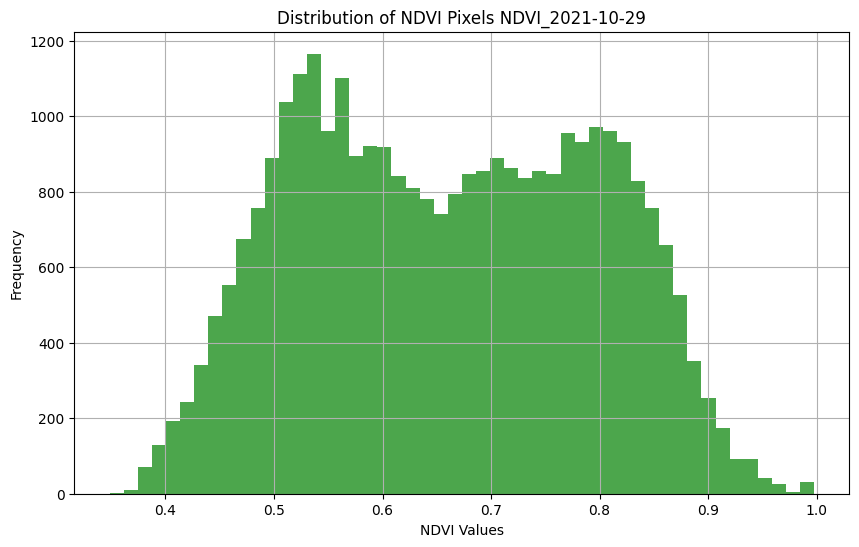

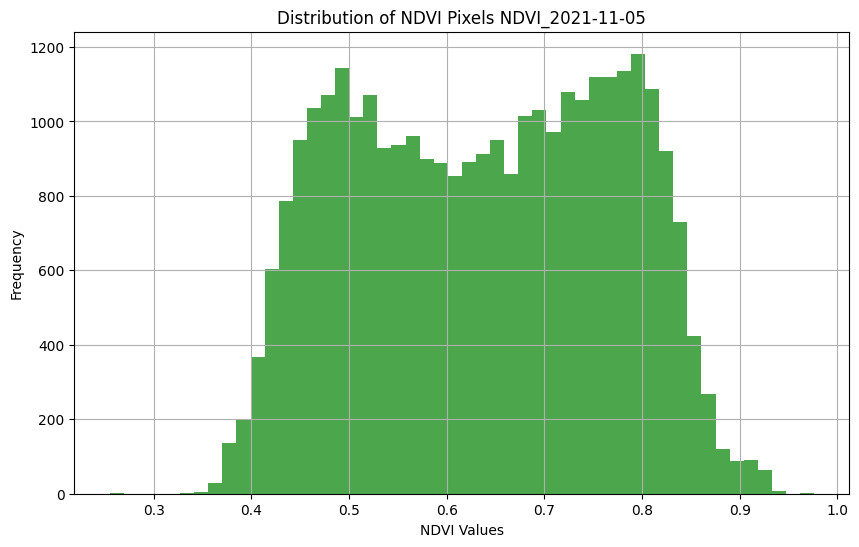

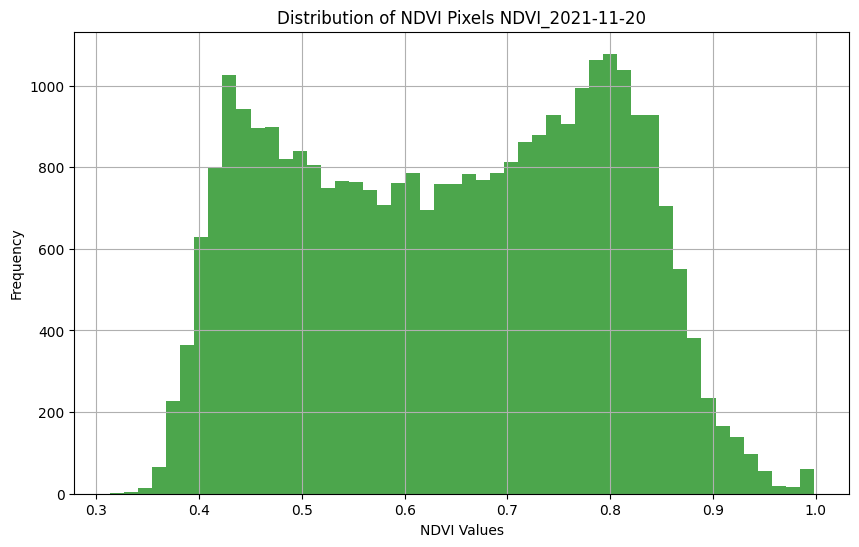

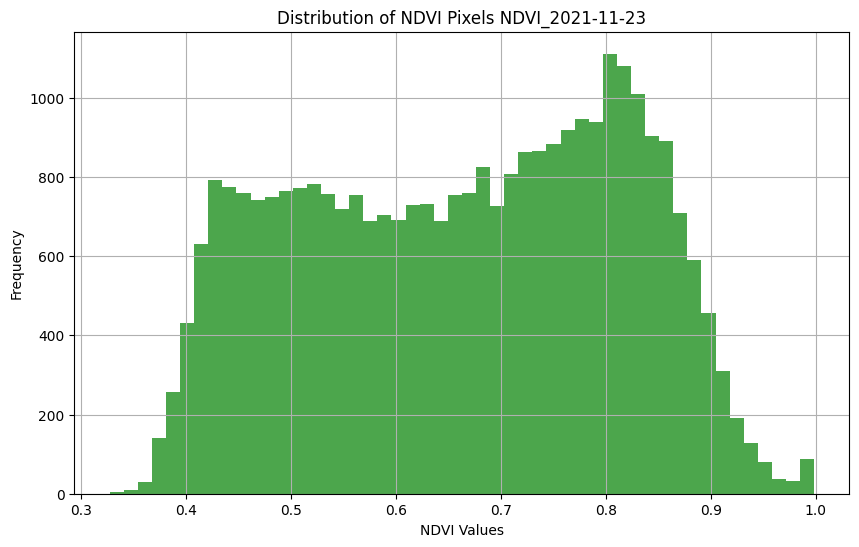

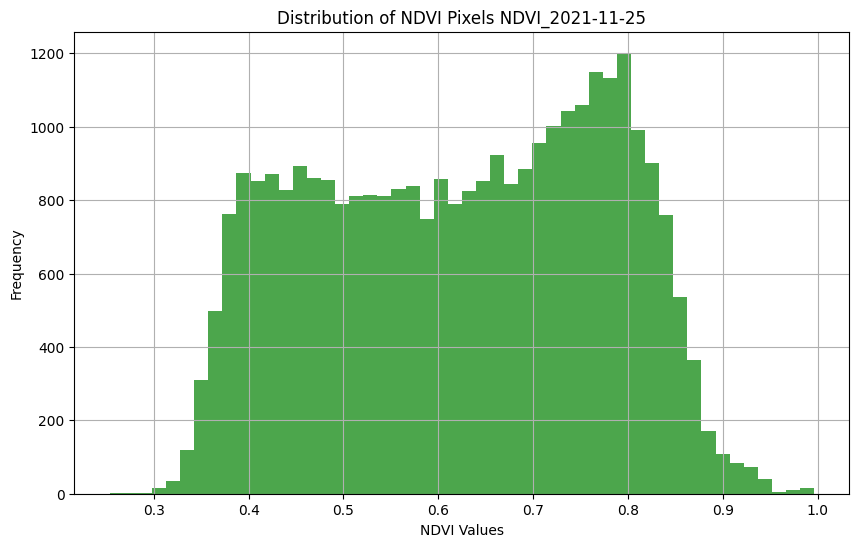

In [11]:
import matplotlib.pyplot as plt
for val in list(data_cube_aoi.keys()):
    # Flatten the NDVI array across all time steps
    if val.startswith('NDVI_'):
        ndvi_flat = data_cube_aoi[val].values.flatten()
        
        # Plot the histogram of NDVI values
        plt.figure(figsize=(10, 6))
        plt.hist(ndvi_flat, bins=50, color='green', alpha=0.7)
        plt.title('Distribution of NDVI Pixels {}'.format(val))
        plt.xlabel('NDVI Values')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()


## Let's calculate average ndvi values for every time interval.

In [12]:
import matplotlib.pyplot as plt

ndvi_mean_values = []
for val in list(data_cube_aoi.keys()):
    # Flatten the NDVI array across all time steps
    if val.startswith('NDVI_'):
        mask = ~np.isnan(data_cube_aoi[val].values)

        # Use the mask to filter out NaN values
        arr_no_nan = data_cube_aoi[val].values[mask]
        ndvi_mean = arr_no_nan.mean()
        x_array = val.split('_')[1]
        ndvi_mean_values.append([x_array, ndvi_mean])
        

### Notice we had to remove all the NaN values from here.

In [13]:
ndvi_mean_values_np = np.array(ndvi_mean_values)

<Axes: xlabel='Date'>

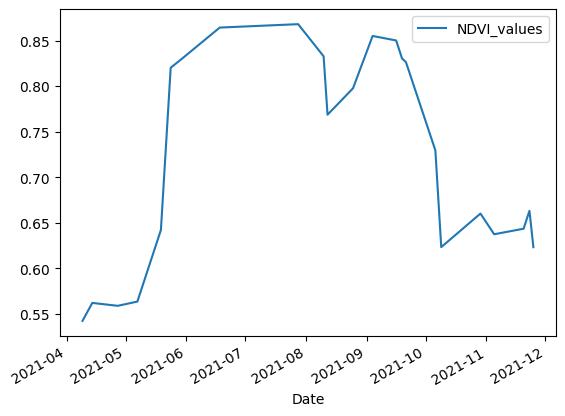

In [14]:

import pandas as pd
values = ndvi_mean_values_np[:, 1]
df = pd.DataFrame({"NDVI_values": values, "Date": ndvi_mean_values_np[:, 0]})
df["Date"] = pd.to_datetime(df["Date"])
df["NDVI_values"] = pd.to_numeric(df["NDVI_values"])
df.set_index('Date').plot()



## Also Let's Compare the ndvi values for the first time interval and last time interval.

### These two dates will be selected 2021-04-09, 2021-11-25

/root/anaconda3/envs/spacesense/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


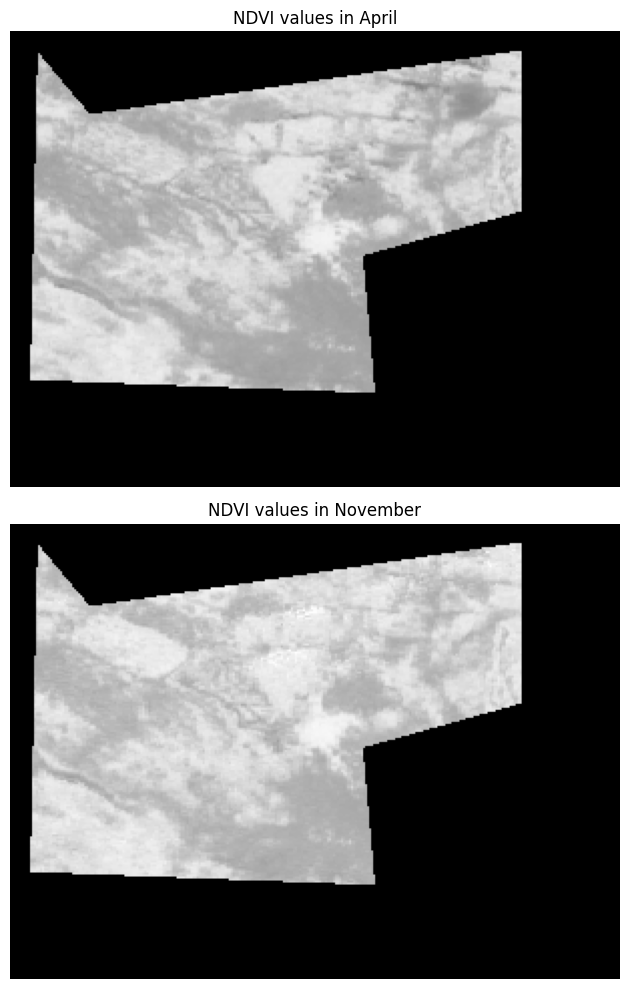

In [15]:
import matplotlib.pyplot as plt

# Assuming rgb_image1 and rgb_image2 are your two RGB images

# Assuming data_cube_aoi contains the NDVI values
ndvi = data_cube_aoi['NDVI_2021-04-09']  # get data for one dimension

# Rescale NDVI values to 0-255 range for display
ndvi_rgb = ((ndvi + 1) * 127.5).astype(np.uint8)

# Create an RGB image where NDVI values are assigned to the red channel
rgb_image_April = np.stack((ndvi_rgb, ndvi_rgb, ndvi_rgb), axis=-1)

# Assuming data_cube_aoi contains the NDVI values
ndvi = data_cube_aoi['NDVI_2021-11-25']  # get data for one dimension

# Rescale NDVI values to 0-255 range for display
ndvi_rgb = ((ndvi + 1) * 127.5).astype(np.uint8)

# Create an RGB image where NDVI values are assigned to the red channel
rgb_image_November = np.stack((ndvi_rgb, ndvi_rgb, ndvi_rgb), axis=-1)


# Create a figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the first RGB image
axs[0].imshow(rgb_image_April)
axs[0].set_title('NDVI values in April')
axs[0].axis('off')

# Plot the second RGB image
axs[1].imshow(rgb_image_November)
axs[1].set_title('NDVI values in November')
axs[1].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Here we can see regions pixel values in November are brighter than others which means ndvi value there is more. 

<h3>Higher NDVI is directly corrletaed to higher vegetataion in the area. 
Therefore plant growth has increased from April to November. 
Since the area is Antartica having increasing vegetation is a sign of rising average temperature. Plant growth is not suppose to happen in this area and is great cause of concern for the global community.</h3> 